
<div style="background-color: darkblue; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">Digit Recognizer using RF Classifier no PCA, w/ PCA and w/ Clustering</h2>
    <p style="text-align: left;"><strong>Author:</strong> Pedro Perez Alvarez</p>
    <p style="text-align: left;"><strong>Date:</strong> 2/16/2025</p>
</div>



<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">I. Introduction</h2>
    <p style="text-align: left;">
    The objective of this assignment is to prepare and analyze the results of three machine learning models: Random Forest Classifier without PCA, Random Forest Classifier with PCA, and K-means clustering. The assignment involves tasks such as data preprocessing, exploratory data analysis (EDA), model comparison, identifying flaws in the provided K-means sample code, and presenting findings through tables, graphs, and conclusions.
    This analysis will utilize the MNIST ("Modified National Institute of Standards and Technology") dataset, a widely recognized benchmark in computer vision for handwritten digit recognition. The dataset, comprising thousands of handwritten images, offers an excellent platform to experiment with various models and compare their performance.
    </p>
</div>


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">II. Libraries load / Data load</h4>
    <p style="text-align: left;">
    </p>
</div>


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY']      = 'you_kaggle_key'

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [16]:
# Data Handling
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import warnings
import logging
from tqdm import tqdm
import time

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# Statistical Analysis
import statsmodels.api as sm
from scipy.stats import spearmanr

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix, precision_recall_curve
)

# Machine Learning Models
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)

import zipfile

warnings.filterwarnings("ignore", category=FutureWarning)

api = KaggleApi()
api.authenticate()

api.competition_download_files('digit-recognizer', path='.', force=True, quiet=False)

with zipfile.ZipFile('digit-recognizer.zip', 'r') as z:
    z.extractall('.')


import pandas as pd
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')



100%|██████████| 15.3M/15.3M [00:00<00:00, 1.45GB/s]

<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">III. Data Presentation</h2>
    <p style="text-align: left;">
        <a href="https://www.kaggle.com/c/digit-recognizer/data" target="_blank" style="color: white; text-decoration: underline;">
        Per Digit Recognizer in the Kaggle Site
        </a>
        ,the data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.  The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero). The train and test datasets have 42,000 and 28,000 observations,respectively.
    </p>
</div>


In [17]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train_data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [81]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
test_data.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [20]:
train_data.shape


(42000, 785)

In [21]:
test_data.shape

(28000, 784)

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">IV. EDA of Initial Dataset</h4>
    <p style="text-align: left;"></p>
</div>

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object


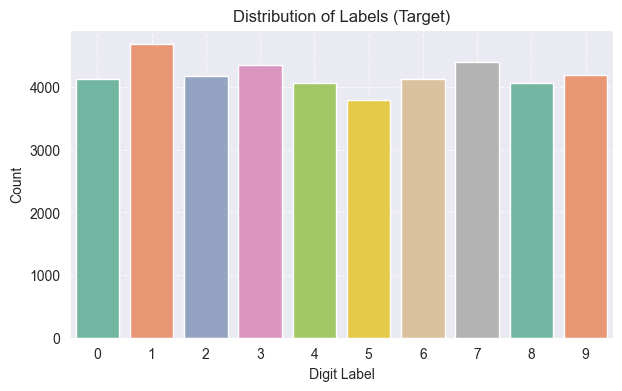

Missing Data Summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage (%)]
Index: []
No missing data found in the dataset.
Total Duplicate Records: 0
Pixel Columns Data Type: [dtype('int32')]
Label Column Data Type: int64

Pixel Intensity Variance Outliers:
       label  pixel_variance                    Outlier_Type
15         1     2124.919254   Low Variance (Possibly Blank)
77         1     2070.743645   Low Variance (Possibly Blank)
371        1     1836.076935   Low Variance (Possibly Blank)
529        1     1717.986862   Low Variance (Possibly Blank)
578        7     2099.742277   Low Variance (Possibly Blank)
...      ...             ...                             ...
41402      0    11685.968630  High Variance (Possibly Noise)
41406      8    10976.718423  High Variance (Possibly Noise)
41508      0    11189.465420  High Variance (Possibly Noise)
41626      0    11468.192972  High Variance (Possibly Noise)
41636      0    11209.201500  High Variance (Possibly Noise

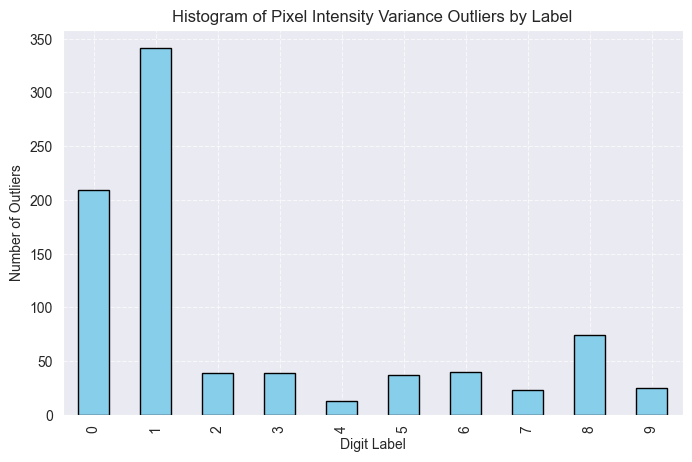

Total number of outliers identified: 840


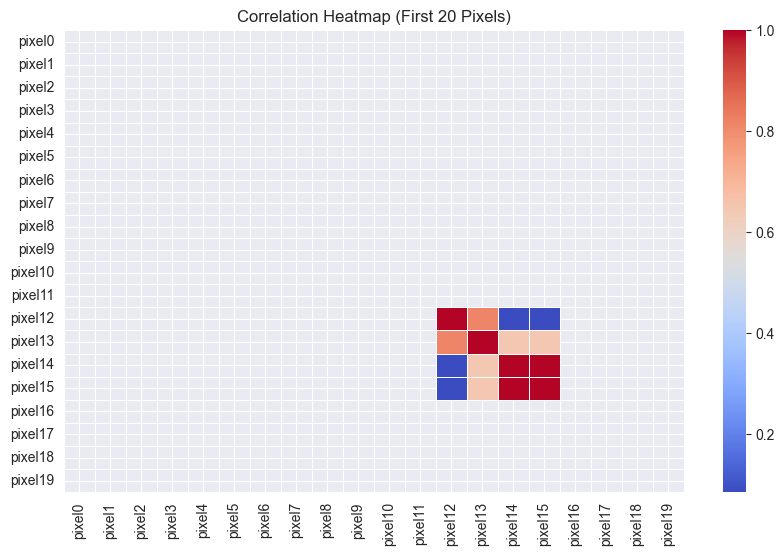

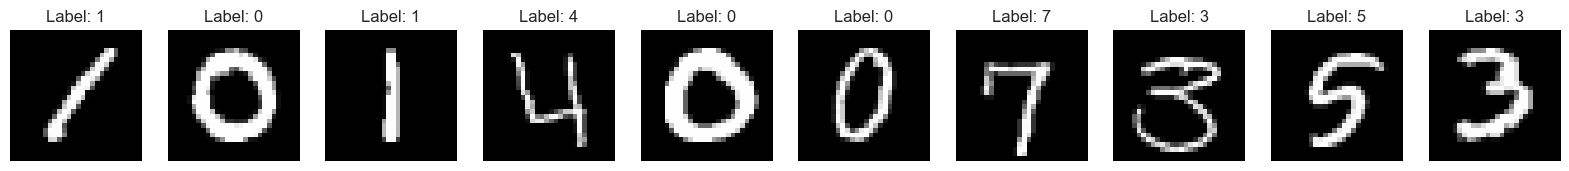

In [85]:
### THIS SESSION INVESTIGATES TRAIN DATA ###

print(train_data.dtypes)

## Distribution of Label (Y-Response)  ##

plt.figure(figsize=(7, 4))
sns.countplot(x='label', data=train_data, palette='Set2', legend=False)
plt.title("Distribution of Labels (Target)")
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Calculate missing values for each column ##

missing_data = train_data.isnull().sum()
missing_percentage = (missing_data / len(train_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

# Check for values less than 0
less_than_zero = (train_data < 0).sum()
less_than_zero = less_than_zero[less_than_zero > 0]

# Check for values greater than 255
greater_than_255 = (train_data > 255).sum()
greater_than_255 = greater_than_255[greater_than_255 > 0]

# Check for duplicates
duplicate_count = train_data.duplicated().sum()
print(f"Total Duplicate Records: {duplicate_count}")

# Ensure pixel columns are integers
pixel_columns = [col for col in train_data.columns if col != 'label']

# Convert pixels to integer (if not already)
train_data[pixel_columns] = train_data[pixel_columns].astype(np.int32)

# Verify data types
pixel_dtype_check = train_data[pixel_columns].dtypes.unique()
label_dtype_check = train_data['label'].dtype

print(f"Pixel Columns Data Type: {pixel_dtype_check}")
print(f"Label Column Data Type: {label_dtype_check}")

### Investigate Outliers by checking Pixel Intensity  ###

# Identify pixel columns (excluding label)
pixel_columns = [col for col in train_data.columns if col != 'label']

train_data = train_data.copy()

# Calculate pixel intensity variance for each image
train_data['pixel_variance'] = train_data[pixel_columns].var(axis=1)

# Identify images with extremely low or high variance (Potential Outliers)
low_variance_threshold = train_data['pixel_variance'].quantile(0.01)  # Bottom 1%
high_variance_threshold = train_data['pixel_variance'].quantile(0.99)  # Top 1%

low_variance_outliers = train_data[train_data['pixel_variance'] < low_variance_threshold]
high_variance_outliers = train_data[train_data['pixel_variance'] > high_variance_threshold]

# Combine results
variance_outliers = pd.concat([
    low_variance_outliers.assign(Outlier_Type='Low Variance (Possibly Blank)'),
    high_variance_outliers.assign(Outlier_Type='High Variance (Possibly Noise)')
])

# Display results directly
print("\nPixel Intensity Variance Outliers:")
print(variance_outliers[['label', 'pixel_variance', 'Outlier_Type']])

# Save results to CSV
output_path = r'C:\Users\pgper\PyCharmMiscProject\pixel_intensity_variance_outliers.csv'
variance_outliers.to_csv(output_path, index=False)
print(f"\nOutlier details saved to '{output_path}'")

# Create a histogram of outliers by label
plt.figure(figsize=(8, 5))
variance_outliers['label'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Histogram of Pixel Intensity Variance Outliers by Label')
plt.xlabel('Digit Label')
plt.ylabel('Number of Outliers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Show total number of outliers identified
total_outliers = len(variance_outliers)
print(f"Total number of outliers identified: {total_outliers}")

# Check pixel value distribution
pixel_columns = [col for col in train_data.columns if 'pixel' in col]

corr_matrix = train_data[pixel_columns[:20]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Heatmap (First 20 Pixels)")
plt.show()

# Display Sample Images (First 10)
plt.figure(figsize=(20, 16))
for i in range(10):
    pixels = np.array(train_data.iloc[i, 1:].values, dtype=np.float32)[:784]
    image = pixels.reshape(28, 28)
    plt.subplot(1, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {train_data.iloc[i, 0]}")
    plt.axis('off')
plt.show()



In [88]:
### THIS SESSION INVESTIGATES TEST DATA ###

# MISSING VALUES CHECK #

# Calculate missing values for each column
missing_data = test_data.isnull().sum()
missing_percentage = (missing_data / len(test_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values

print("Missing Data Summary:")
print(missing_summary)

# Visualize missing data if any
if not missing_summary.empty:
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

# DATA VALIDATION CHECKS #

# Check for values less than 0
less_than_zero = (test_data < 0).sum()
less_than_zero = less_than_zero[less_than_zero > 0]

# Check for values greater than 255
greater_than_255 = (test_data > 255).sum()
greater_than_255 = greater_than_255[greater_than_255 > 0]

# Check for duplicates
duplicate_count = test_data.duplicated().sum()
print(f"Total Duplicate Records: {duplicate_count}")

# DATA TYPE VALIDATION #

# Ensure pixel columns are integers and labels are categorical
pixel_columns = [col for col in test_data.columns if col != 'label']

# Convert pixels to integer (if not already)
test_data[pixel_columns] = test_data[pixel_columns].astype(np.int32)

# Verify data types
pixel_dtype_check = test_data[pixel_columns].dtypes.unique()
print(f"Pixel Columns Data Type: {pixel_dtype_check}")

# Identify pixel columns (excluding label)
pixel_columns = [col for col in test_data.columns if col != 'label']

test_data = test_data.copy()

# Calculate pixel intensity variance for each image
test_data['pixel_variance'] = test_data[pixel_columns].var(axis=1)

# Identify images with extremely low or high variance (Potential Outliers)
low_variance_threshold = test_data['pixel_variance'].quantile(0.01)  # Bottom 1%
high_variance_threshold = test_data['pixel_variance'].quantile(0.99)  # Top 1%

low_variance_outliers = test_data[test_data['pixel_variance'] < low_variance_threshold]
high_variance_outliers = test_data[test_data['pixel_variance'] > high_variance_threshold]

# Combine results
variance_outliers = pd.concat([
    low_variance_outliers.assign(Outlier_Type='Low Variance (Possibly Blank)'),
    high_variance_outliers.assign(Outlier_Type='High Variance (Possibly Noise)')
])



# VALUE RANGE VALIDATION #

if not less_than_zero.empty:
    print("\nColumns with values less than 0:")
    print(less_than_zero)
else:
    print("\nNo values less than 0 found.")

if not greater_than_255.empty:
    print("\nColumns with values greater than 255:")
    print(greater_than_255)
else:
    print("\nNo values greater than 255 found.")


Missing Data Summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage (%)]
Index: []
No missing data found in the dataset.
Total Duplicate Records: 0
Pixel Columns Data Type: [dtype('int32')]

No values less than 0 found.

Columns with values greater than 255:
pixel_variance    28000
dtype: int64


<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">V. Overview of Findings and Next Steps</h2>
    <p style="text-align: left;">
    </p>
</div>


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">VI. Cleansing and Preprocessing</h4>
    <p style="text-align: left;">
    </p>
</div>


In [89]:
## Data Cleaning ##

## Identify corrupt images ##

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Identify corrupt images (uniform pixel values)
logging.info("Checking for corrupt images...")
uniform_images = train_data.iloc[:, 1:].apply(lambda x: x.nunique() == 1, axis=1)
corrupt_images = train_data[uniform_images]

# Display count of corrupt images
corrupt_count = len(corrupt_images)
logging.info(f"Number of corrupt images: {corrupt_count}")

# Visualize a few corrupt images (if any)
if corrupt_count > 0:
    logging.info("Displaying sample corrupt images...")
    plt.figure(figsize=(10, 5))
    for i, (_, row) in enumerate(corrupt_images.head(5).iterrows()):
        image = np.array(row.iloc[1:].values, dtype=np.float32).reshape(28, 28)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.suptitle('Sample Corrupt Images (Uniform Pixels)')
    plt.show()
else:
    logging.info("No corrupt images found.")



Checking for corrupt images...
Number of corrupt images: 0
No corrupt images found.


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">VII. Feature Engineering</h4>
    <p style="text-align: left;">
    </p>
</div>

In [90]:
## Feature Engineering ##

## Convert Grayscale to Binary Pixel Scale ##
def binarize_pixels(df, threshold=128):
    pixel_columns = df.columns[df.columns.str.startswith('pixel')]
    df[pixel_columns] = (df[pixel_columns] >= threshold).astype(int)
    return df

# Perform Binarization on Train Data
train_data = binarize_pixels(train_data)
print("Train data converted to binary scale and saved.")

# Perform Binarization on Test Data
test_data = binarize_pixels(test_data)
print("Test data converted to binary scale and saved.")

# Compute Pixel Intensity Mean
def compute_pixel_mean(df):
    df['pixel_mean'] = df.loc[:, df.columns.str.startswith('pixel')].mean(axis=1)
    return df

# Compute Horizontal Symmetry
def compute_horizontal_symmetry(row):
    pixels = row.loc[row.index.str.startswith('pixel')].values[:784]  # Use only first 784 values
    image = pixels.reshape(28, 28)
    left_half = image[:, :14]
    right_half = np.fliplr(image[:, 14:])
    return np.mean(left_half == right_half)

# Compute Vertical Symmetry
def compute_vertical_symmetry(row):
    pixels = row.loc[row.index.str.startswith('pixel')].values[:784]  # Use only first 784 values
    image = pixels.reshape(28, 28)
    top_half = image[:14, :]
    bottom_half = np.flipud(image[14:, :])
    return np.mean(top_half == bottom_half)

# Apply Feature Engineering
def add_features(df):
    df = compute_pixel_mean(df)
    df['horizontal_symmetry'] = df.apply(compute_horizontal_symmetry, axis=1)
    df['vertical_symmetry'] = df.apply(compute_vertical_symmetry, axis=1)
    return df

train_data = train_data.copy()
test_data = test_data.copy()

# Perform Feature Engineering on train_data
train_data = add_features(train_data)
print("Train data feature engineering complete.")

# Perform Feature Engineering on test_data
test_data = add_features(test_data)
print("Test data feature engineering complete.")




Train data converted to binary scale and saved.
Test data converted to binary scale and saved.
Train data feature engineering complete.
Test data feature engineering complete.


In [66]:
train_data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel_variance,pixel_mean,horizontal_symmetry,vertical_symmetry
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000071,0.0,0.0,0.0,0.0,0.0,1.0,0.133728,0.855166,0.842298
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008451,0.0,0.0,0.0,0.0,0.0,0.0,0.044214,0.045104,0.052713
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.026752,0.673469,0.612245
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.101911,0.826531,0.808673
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.129936,0.859694,0.844388
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.161783,0.885204,0.875000
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.398726,1.000000,1.000000


<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">VIII. Overview of the Cleaned Dataset</h2>
    <p style="text-align: left;">
    </p>
</div>

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">IX. Final EDA and Comparisons</h4>
    <p style="text-align: left;">
    </p>
</div>

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


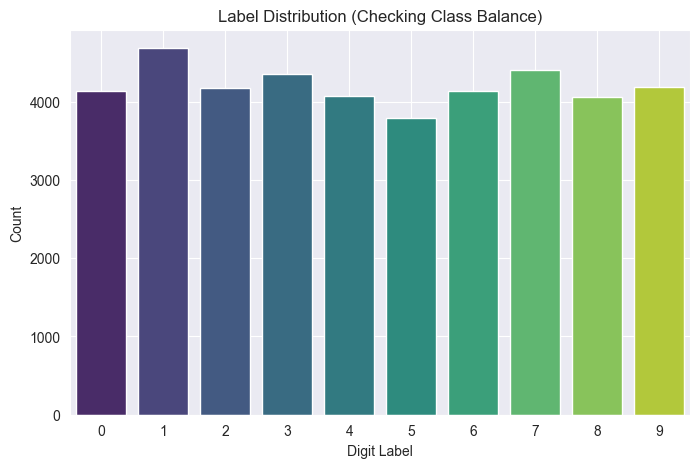

In [91]:
train_data = train_data.copy()

plt.figure(figsize=(8, 5))
sns.countplot(x=train_data['label'], palette='viridis')  # Plot with cleaned numeric labels
plt.title('Label Distribution (Checking Class Balance)')
plt.xlabel('Digit Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()




Pixel Intensity Variance Outliers:
       label  pixel_variance                    Outlier_Type
15         1        0.044494   Low Variance (Possibly Blank)
77         1        0.039979   Low Variance (Possibly Blank)
371        1        0.039979   Low Variance (Possibly Blank)
388        1        0.049149   Low Variance (Possibly Blank)
424        1        0.049149   Low Variance (Possibly Blank)
...      ...             ...                             ...
41508      0        0.191813  High Variance (Possibly Noise)
41626      0        0.198973  High Variance (Possibly Noise)
41636      0        0.197653  High Variance (Possibly Noise)
41787      8        0.190415  High Variance (Possibly Noise)
41805      6        0.189437  High Variance (Possibly Noise)

[839 rows x 3 columns]

Outlier details saved to 'C:\Users\pgper\PyCharmMiscProject\pixel_intensity_variance_outliers.csv'


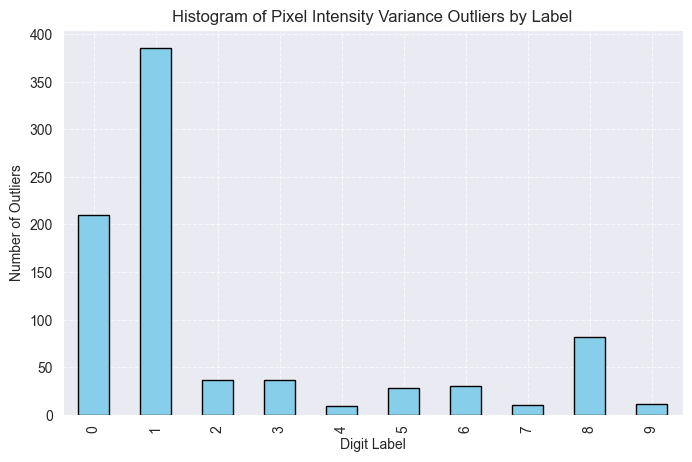

Total number of outliers identified: 839


In [92]:
### Check Outliers (Pixel Intensity) after changes###

# Identify pixel columns (excluding label)
pixel_columns = [col for col in train_data.columns if col != 'label']

train_data = train_data.copy()

# Calculate pixel intensity variance for each image
train_data['pixel_variance'] = train_data[pixel_columns].var(axis=1)

# Identify images with extremely low or high variance (Potential Outliers)
low_variance_threshold = train_data['pixel_variance'].quantile(0.01)  # Bottom 1%
high_variance_threshold = train_data['pixel_variance'].quantile(0.99)  # Top 1%

low_variance_outliers = train_data[train_data['pixel_variance'] < low_variance_threshold]
high_variance_outliers = train_data[train_data['pixel_variance'] > high_variance_threshold]

# Combine results
variance_outliers = pd.concat([
    low_variance_outliers.assign(Outlier_Type='Low Variance (Possibly Blank)'),
    high_variance_outliers.assign(Outlier_Type='High Variance (Possibly Noise)')
])

# Display results directly
print("\nPixel Intensity Variance Outliers:")
print(variance_outliers[['label', 'pixel_variance', 'Outlier_Type']])

# Save results to CSV
output_path = r'C:\Users\pgper\PyCharmMiscProject\pixel_intensity_variance_outliers.csv'
variance_outliers.to_csv(output_path, index=False)
print(f"\nOutlier details saved to '{output_path}'")

# Create a histogram of outliers by label
plt.figure(figsize=(8, 5))
variance_outliers['label'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Histogram of Pixel Intensity Variance Outliers by Label')
plt.xlabel('Digit Label')
plt.ylabel('Number of Outliers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Show total number of outliers identified
total_outliers = len(variance_outliers)
print(f"Total number of outliers identified: {total_outliers}")

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


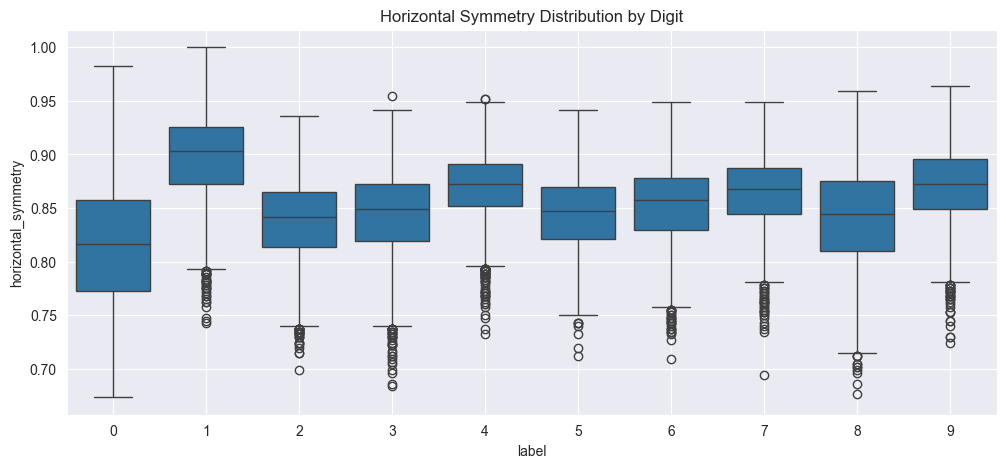

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


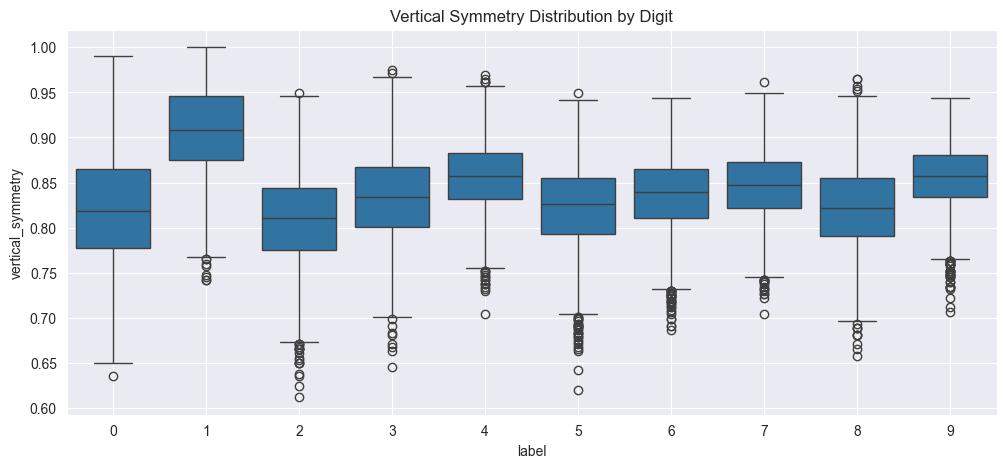

In [93]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=train_data['label'], y=train_data['horizontal_symmetry'])
plt.title('Horizontal Symmetry Distribution by Digit')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=train_data['label'], y=train_data['vertical_symmetry'])
plt.title('Vertical Symmetry Distribution by Digit')
plt.grid(True)
plt.show()


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">X. Data Preprocessing Specific to the Model</h4>
    <p style="text-align: left;">
    </p>
</div>

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">XI. Splitting</h4>
    <p style="text-align: left;"></p>
</div>

In [94]:
# Define X and Y
X = train_data.drop(columns=['label'])
Y = train_data['label']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">XII. Overview of the Steps</h2>
    <p style="text-align: left;">
    </p>
</div>

<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Model 1 -Random Forest Classifier No PCA </h3>
    <p style="text-align: left;">
    </p>
</div>

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">XIII. Model Training Cross-validation</h4>
    <p style="text-align: left;">
    </p>
</div>

In [95]:
# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">XIV. Model Hypertuning</h4>
    <p style="text-align: left;">
    </p>
</div>

In [96]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [10],  # Depth of trees
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples required at a leaf node
    'max_features': ['log2'],  # Maximum features considered for splitting
    'criterion' : ['gini']
}

In [97]:
## Model 1- Random Forest Classifier ##

# Initialize a Random Forest Classifier and GridSearchCV
rf = RandomForestClassifier(class_weight={0:1, 1:2}, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)

# Perform the grid search on the training data
start_time = time.time()
grid_search.fit(X_train, Y_train)
end_time = time.time()
print(f"Grid Search Training Time: {end_time - start_time:.2f} seconds")

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

# Train the Random Forest Classifier with the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42)
start_time = time.time()
best_model.fit(X_train, Y_train)
end_time = time.time()
print(f"Final Model Training Time: {end_time - start_time:.2f} seconds")


Fitting 30 folds for each of 8 candidates, totalling 240 fits
Grid Search Training Time: 83.83 seconds
Best Hyperparameters Found: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Final Model Training Time: 1.47 seconds


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">XV. Model Testing</h4>
    <p style="text-align: left;">
    </p>
</div>

In [98]:

## Predict using the TEST Data ##
test_predictions = best_model.predict(test_data)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Label": test_predictions
})

# Create test_data_id based on the length of test_results
test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predictions) + 1)})

# Prepare final submission file
final_submission = pd.DataFrame({
    "ImageId": test_data_id["ImageId"],  # Ensure PassengerId is included
    "Label": test_results["Label"]  # Add Survived predictions
})

# Save to CSV
final_submission.to_csv("rf_classifier_submission.csv", index=False)  # Updated filename
print("Submission saved to 'rf_classifier_submission.csv'")

Submission saved to 'rf_classifier_submission.csv'


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">XVI. Model Evaluation </h4>
    <p style="text-align: left;">
    </p>
</div>

In [99]:

# Make predictions
y_pred_tuned = best_model.predict(X_test)

# Compute Classification Metrics
accuracy = accuracy_score(Y_test, y_pred_tuned)
conf_matrix = confusion_matrix(Y_test, y_pred_tuned)
class_report = classification_report(Y_test, y_pred_tuned)

# Output the best hyperparameters and evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Evaluation Metrics:
Accuracy: 0.9187
Confusion Matrix:
 [[1170    0    3    0    1    0   20    0    5    1]
 [   0 1375    2    1    0    2    5    2    2    0]
 [  11   22 1175   12   18    2   11   27   14    2]
 [   6   19   19 1203    3   29    8   22   29   17]
 [   2   11    4    0 1109    0   20    4    6   66]
 [  15   13    4   50   10  951   23    1    7   11]
 [  21    9    3    0    5    8 1206    0    4    0]
 [   2   39   21    2   13    1    0 1243    3   35]
 [   2   31    8   46   11   17   11    7 1057   19]
 [   9   14    7   22   39    5    3   38    8 1086]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1200
           1       0.90      0.99      0.94      1389
           2       0.94      0.91      0.93      1294
           3       0.90      0.89      0.89      1355
           4       0.92      0.91      0.91      1222
           5       0.94      0.88      0.91      1085
          

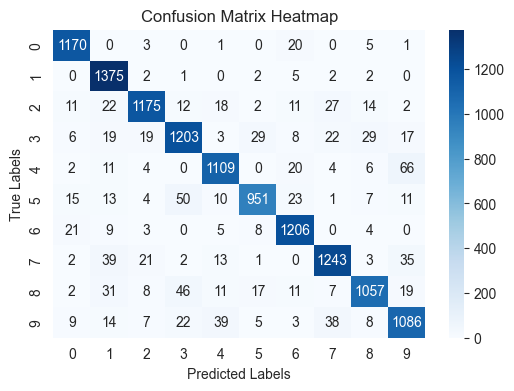

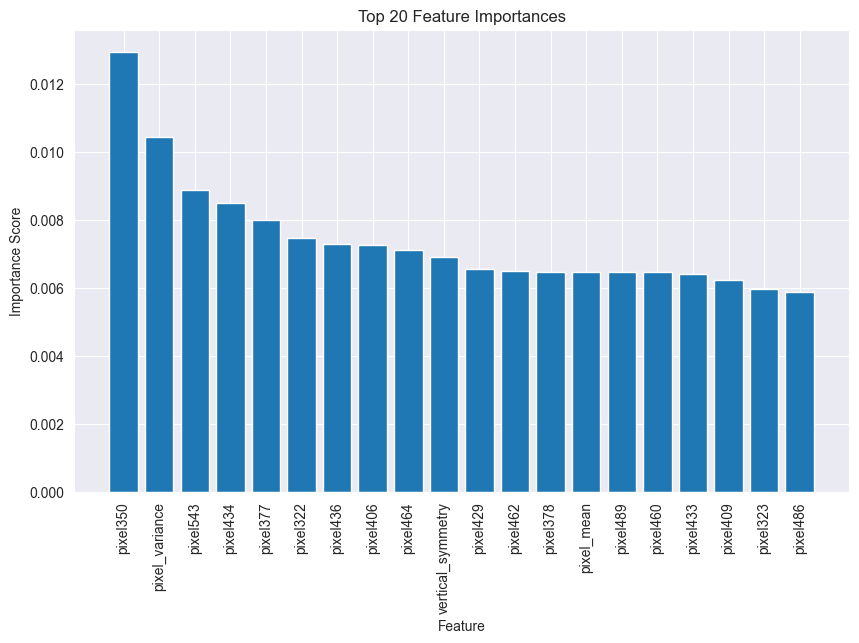

In [109]:
# Additional Evaluation of Random Forest Classifier

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(Y_test, best_model.predict(X_test))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(conf_matrix.shape[1])],
            yticklabels=[str(i) for i in range(conf_matrix.shape[0])])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.grid(True)
plt.show()

# Feature Importance Plot
importances = best_model.feature_importances_
feature_names = X_train.columns[:len(importances)]
indices = np.argsort(importances)[::-1]

# Show only the top 20 most important features
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_n = 20  # Limit to top 20 features
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.grid(True)
plt.show()

<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Model 2 -Random Forest Classifier with PCA </h3>
    <p style="text-align: left;">
    </p>
</div>

In [111]:
## Model 2- Random Forest Classifier with PCA##

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize a Random Forest Classifier and GridSearchCV
rf = RandomForestClassifier(class_weight={0: 1, 1: 2}, random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Perform the grid search on the PCA-transformed training data
start_time = time.time()
grid_search.fit(X_train_pca, Y_train)
end_time = time.time()
print(f"Grid Search Training Time: {end_time - start_time:.2f} seconds")

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

# Train the Random Forest Classifier with the best hyperparameters on PCA-transformed data
best_model = RandomForestClassifier(**best_params, random_state=42)
start_time = time.time()
best_model.fit(X_train_pca, Y_train)
end_time = time.time()
print(f"Final Model Training Time: {end_time - start_time:.2f} seconds")

# Optional: Evaluate on Test Set
test_accuracy = best_model.score(X_test_pca, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optional: Print PCA Explained Variance
print(f"Number of PCA components: {pca.n_components_}")
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.2f}")


Fitting 30 folds for each of 8 candidates, totalling 240 fits
Grid Search Training Time: 238.06 seconds
Best Hyperparameters Found: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Final Model Training Time: 15.85 seconds
Test Accuracy: 0.8925
Number of PCA components: 266
Explained Variance Ratio: 0.95


In [114]:
# Apply the same PCA transformation to the test data
test_data_pca = pca.transform(test_data)

## Predict using the TEST Data ##
test_predictions = best_model.predict(test_data_pca)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Label": test_predictions
})

# Create test_data_id based on the length of test_results
test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predictions) + 1)})

# Prepare final submission file
final_submission = pd.DataFrame({
    "ImageId": test_data_id["ImageId"],  # Ensure PassengerId is included
    "Label": test_results["Label"]  # Add Survived predictions
})

# Save to CSV
final_submission.to_csv("rf_classifier_submission_w_PCA.csv", index=False)  # Updated filename
print("Submission saved to 'rf_classifier_submission_w_PCA.csv'")

Submission saved to 'rf_classifier_submission_w_PCA.csv'


In [115]:

# Make predictions
y_pred_tuned = best_model.predict(X_test_pca)

# Compute Classification Metrics
accuracy = accuracy_score(Y_test, y_pred_tuned)
conf_matrix = confusion_matrix(Y_test, y_pred_tuned)
class_report = classification_report(Y_test, y_pred_tuned)

# Output the best hyperparameters and evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Evaluation Metrics:
Accuracy: 0.8925
Confusion Matrix:
 [[1130    1    3   10    3    9   29    4    8    3]
 [   2 1360    6    4    1    2    5    3    6    0]
 [  10   19 1133   32   19    3   17   19   40    2]
 [  12    6   33 1179    4   44   16   13   29   19]
 [   3   13    4    6 1095    4   15    6    8   68]
 [  16    3   14   73   18  882   35    6   29    9]
 [  22    3    4    0    5   11 1199    2   10    0]
 [   9   34   26    3   15    2    3 1211   10   46]
 [  13   14   21   77    9   23   11    4 1012   25]
 [   9   13    5   28   47    8    4   62   11 1044]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1200
           1       0.93      0.98      0.95      1389
           2       0.91      0.88      0.89      1294
           3       0.83      0.87      0.85      1355
           4       0.90      0.90      0.90      1222
           5       0.89      0.81      0.85      1085
          

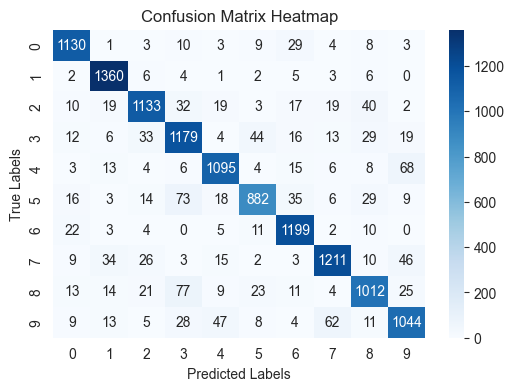

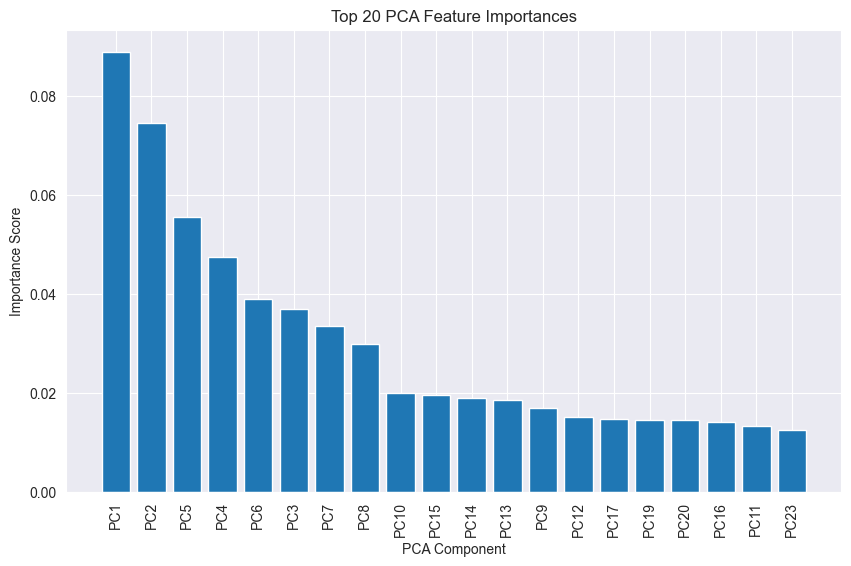

In [117]:
# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(Y_test, best_model.predict(X_test_pca))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(conf_matrix.shape[1])],
            yticklabels=[str(i) for i in range(conf_matrix.shape[0])])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.grid(True)
plt.show()


# FEATURE IMPORTANCE PLOT (PCA)

importances = best_model.feature_importances_

# Create feature names for PCA components
feature_names = [f'PC{i+1}' for i in range(len(importances))]

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Show only the top 20 most important features
top_n = 20  # Limit to top 20 features
plt.figure(figsize=(10, 6))
plt.title("Top 20 PCA Feature Importances")
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel("PCA Component")
plt.ylabel("Importance Score")
plt.grid(True)
plt.show()


<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Model 3 K-Means Clustering </h3>
    <p style="text-align: left;">
    </p>
</div>

In [122]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ==========================
# FUNCTION DEFINITIONS (Fixed Indexing for actual_labels)
# ==========================
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    actual_labels = np.asarray(actual_labels)  # Ensure NumPy array
    for i in range(kmeans.n_clusters):
        index = np.where(kmeans.labels_ == i)[0]
        cluster_labels = actual_labels[index]
        if len(cluster_labels) > 0:
            counts = np.bincount(cluster_labels)
            inferred_labels[np.argmax(counts)] = [i]
    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels), dtype=np.uint8)
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
    return predicted_labels

# ==========================
# MODEL TRAINING (KMEANS)
# ==========================
n_digits = len(np.unique(Y_test))
kmeans = MiniBatchKMeans(n_clusters=n_digits, random_state=42)
start_time = time.time()
kmeans.fit(X_train)
end_time = time.time()
print(f"KMeans Training Time: {end_time - start_time:.2f} seconds")

# ==========================
# X_TEST DATA PREDICTION & EVALUATION
# ==========================
X_test_clusters = kmeans.predict(X_test)
X_test_predictions = infer_data_labels(X_test_clusters, infer_cluster_labels(kmeans, np.asarray(Y_train)))

accuracy = accuracy_score(Y_test, X_test_predictions)
conf_matrix = confusion_matrix(Y_test, X_test_predictions)
class_report = classification_report(Y_test, X_test_predictions)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# ==========================
# TEST DATA PREDICTION FOR SUBMISSION
# ==========================
test_clusters = kmeans.predict(test_data)
test_predictions = infer_data_labels(test_clusters, infer_cluster_labels(kmeans, np.asarray(Y_train)))
test_results = pd.DataFrame({"Label": test_predictions})
test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predictions) + 1)})
final_submission = pd.DataFrame({
    "ImageId": test_data_id["ImageId"],
    "Label": test_results["Label"]
})
final_submission.to_csv("kmeans_classifier_submission.csv", index=False)
print("Submission saved to 'kmeans_classifier_submission.csv'")

KMeans Training Time: 0.69 seconds
Evaluation Metrics:
Accuracy: 0.4895
Confusion Matrix:
 [[ 970    0   17   82    5   77   48    1    0    0]
 [ 834  550    0    1    0    2    2    0    0    0]
 [ 140  157  827   76   22   12   43   17    0    0]
 [ 151   34   45  906   41  161   11    6    0    0]
 [ 501   37   12    0  561   86   22    3    0    0]
 [ 115   35    9  387   47  467   25    0    0    0]
 [ 113   12   36    6   23   54 1012    0    0    0]
 [ 166   86   12    0  211    9    0  875    0    0]
 [ 187  196   19  334   44  408   14    7    0    0]
 [ 427   26    3   19  522  167    2   65    0    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.81      0.40      1200
           1       0.49      0.40      0.44      1389
           2       0.84      0.64      0.73      1294
           3       0.50      0.67      0.57      1355
           4       0.38      0.46      0.42      1222
           5       0.32      

C:\Users\pgper\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pgper\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pgper\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Model 4 K-Means Clustering with Correction - PCA and Scaling</h3>
    <p style="text-align: left;">
    </p>
</div>

In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from scipy.stats import mode

train_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/6_ModelAssignment6/train.csv", header=0, sep=",")
test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/6_ModelAssignment6/test.csv", header=0, sep=",")
#
# # Define X and Y
# X = train_data.drop(columns=['label'])
# Y = train_data['label']
#
# # Split the data
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
#
# # ==========================
# # FUNCTION DEFINITIONS (Fixed Indexing for actual_labels)
# # ==========================
# def infer_cluster_labels(kmeans, actual_labels):
#     inferred_labels = {}
#     actual_labels = np.asarray(actual_labels)  # Ensure NumPy array
#     for i in range(kmeans.n_clusters):
#         index = np.where(kmeans.labels_ == i)[0]
#         cluster_labels = actual_labels[index]
#         if len(cluster_labels) > 0:
#             counts = np.bincount(cluster_labels)
#             inferred_labels[np.argmax(counts)] = [i]
#     return inferred_labels
#
# def infer_data_labels(X_labels, cluster_labels):
#     predicted_labels = np.zeros(len(X_labels), dtype=np.uint8)
#     for i, cluster in enumerate(X_labels):
#         for key, value in cluster_labels.items():
#             if cluster in value:
#                 predicted_labels[i] = key
#     return predicted_labels
#
# # ==========================
# # DATA PREPROCESSING WITH SCALING AND PCA
# # ==========================
# scaler = StandardScaler()
# pca = PCA(n_components=0.95)
#
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# test_data_scaled = scaler.transform(test_data)
#
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
# test_data_pca = pca.transform(test_data_scaled)
#
# # ==========================
# # MODEL TRAINING (KMEANS)
# # ==========================
# n_digits = len(np.unique(Y_test))
# kmeans = MiniBatchKMeans(n_clusters=n_digits, random_state=42)
# start_time = time.time()
# kmeans.fit(X_train_pca)
# end_time = time.time()
# print(f"KMeans Training Time: {end_time - start_time:.2f} seconds")
#
# # ==========================
# # X_TEST DATA PREDICTION & EVALUATION
# # ==========================
# X_test_clusters = kmeans.predict(X_test_pca)
# X_test_predictions = infer_data_labels(X_test_clusters, infer_cluster_labels(kmeans, np.asarray(Y_train)))
#
# accuracy = accuracy_score(Y_test, X_test_predictions)
# conf_matrix = confusion_matrix(Y_test, X_test_predictions)
# class_report = classification_report(Y_test, X_test_predictions)
#
# print("Evaluation Metrics:")
# print(f"Accuracy: {accuracy:.4f}")
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)
#
# # ==========================
# # TEST DATA PREDICTION FOR SUBMISSION
# # ==========================
# test_clusters = kmeans.predict(test_data_pca)
# test_predictions = infer_data_labels(test_clusters, infer_cluster_labels(kmeans, np.asarray(Y_train)))
# test_results = pd.DataFrame({"Label": test_predictions})
# test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predictions) + 1)})
# final_submission = pd.DataFrame({
#     "ImageId": test_data_id["ImageId"],
#     "Label": test_results["Label"]
# })
# final_submission.to_csv("kmeans_classifier_submission.csv", index=False)
# print("Submission saved to 'kmeans_classifier_submission.csv'")
#

# ==========================
# 1️⃣ DATA LOADING (TRAINING SAMPLE)
# ==========================
X_train = train_data.drop(columns=['label']).values
y_train = train_data['label'].values
X_test = test_data.values


# ==========================
# 3️⃣ DATA PREPROCESSING (SCALING & PCA)
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# ==========================
# 4️⃣ MINI-BATCH K-MEANS with Hyperparameters
# ==========================
mini_kmeans = MiniBatchKMeans(
    n_clusters=len(np.unique(y_train)),
    random_state=42,
    batch_size=64,
    n_init=20,
    max_iter=300,
    tol=1e-4
)

start_time = time.time()
mini_kmeans.fit(X_train_pca)
end_time = time.time()
print(f"MiniBatchKMeans Training Time: {end_time - start_time:.2f} seconds")

# ==========================
# 5️⃣ CLUSTER-TO-LABEL MAPPING
# ==========================
def infer_cluster_labels(kmeans, actual_labels):
    cluster_labels = {}
    actual_labels = np.asarray(actual_labels)
    for cluster in range(kmeans.n_clusters):
        indices = np.where(kmeans.labels_ == cluster)[0]
        if len(indices) == 0:
            continue
        cluster_actual_labels = actual_labels[indices]
        most_common = mode(cluster_actual_labels, keepdims=True).mode[0]
        cluster_labels[cluster] = most_common
    return cluster_labels

def infer_data_labels(X_clusters, cluster_labels):
    return np.array([cluster_labels[cluster] for cluster in X_clusters])

mini_cluster_labels = infer_cluster_labels(mini_kmeans, y_train)

# ==========================
# 6️⃣ TRAIN SET EVALUATION
# ==========================
mini_train_clusters = mini_kmeans.predict(X_train_pca)
mini_train_predictions = infer_data_labels(mini_train_clusters, mini_cluster_labels)

mini_train_accuracy = accuracy_score(y_train, mini_train_predictions)
mini_train_classification_report = classification_report(y_train, mini_train_predictions, zero_division=1)
print(f"MiniBatchKMeans Train Accuracy: {mini_train_accuracy:.4f}")
print(mini_train_classification_report)

# ==========================
# 6️⃣ FINAL TEST DATA PREDICTION (Corrected with test_data)
# ==========================
mini_test_clusters = mini_kmeans.predict(X_test_pca)
mini_test_predictions = infer_data_labels(mini_test_clusters, mini_cluster_labels)

# ==========================
# 7️⃣ SAVE FINAL SUBMISSION
# ==========================
mini_submission = pd.DataFrame({
    "ImageId": np.arange(1, len(mini_test_predictions) + 1),
    "Label": mini_test_predictions
})
mini_submission.to_csv("minibatch_kmeans_submission.csv", index=False)


MiniBatchKMeans Training Time: 3.09 seconds
MiniBatchKMeans Train Accuracy: 0.5721
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      4132
           1       0.61      0.99      0.75      4684
           2       0.83      0.65      0.73      4177
           3       0.53      0.63      0.58      4351
           4       0.39      0.37      0.38      4072
           5       1.00      0.00      0.00      3795
           6       0.80      0.78      0.79      4137
           7       0.36      0.82      0.50      4401
           8       0.53      0.57      0.55      4063
           9       1.00      0.00      0.00      4188

    accuracy                           0.57     42000
   macro avg       0.70      0.56      0.51     42000
weighted avg       0.69      0.57      0.52     42000



In [35]:
import time
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans  # Standard K-Means
from sklearn.preprocessing import StandardScaler  # Changed to StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode

# ==========================
# 1️⃣ DATA LOADING (TRAINING SAMPLE & TEST DATA)
# ==========================
train_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/6_ModelAssignment6/train.csv", header=0, sep=",")
test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/6_ModelAssignment6/test.csv", header=0, sep=",")

## Convert Grayscale to Binary Pixel Scale ##
def binarize_pixels(df, threshold=128):
    pixel_columns = df.columns[df.columns.str.startswith('pixel')]
    df[pixel_columns] = (df[pixel_columns] >= threshold).astype(int)
    return df

# Perform Binarization on Train Data
train_data = binarize_pixels(train_data)
print("Train data converted to binary scale and saved.")

# Perform Binarization on Test Data
test_data = binarize_pixels(test_data)
print("Test data converted to binary scale and saved.")

X_train = train_data.drop(columns=['label']).values
y_train = train_data['label'].values
X_test = test_data.values  # Properly using test_data

# ==========================
# 4️⃣ K-MEANS with Hyperparameters
# ==========================
kmeans = KMeans(
    n_clusters=len(np.unique(y_train)),
    random_state=42,
    n_init=200,  # Ensures better clustering by trying multiple initializations
    max_iter=400,
    tol=1e-4
)
start_time = time.time()
kmeans.fit(X_train)  # No PCA applied, using raw scaled data
end_time = time.time()
print(f"KMeans Training Time: {end_time - start_time:.2f} seconds")

# ==========================
# 5️⃣ CLUSTER-TO-LABEL MAPPING
# ==========================
def infer_cluster_labels(kmeans, actual_labels):
    cluster_labels = {}
    actual_labels = np.asarray(actual_labels)
    for cluster in range(kmeans.n_clusters):
        indices = np.where(kmeans.labels_ == cluster)[0]
        if len(indices) == 0:
            continue
        cluster_actual_labels = actual_labels[indices]
        most_common = mode(cluster_actual_labels, keepdims=True).mode[0]
        cluster_labels[cluster] = most_common
    return cluster_labels

def infer_data_labels(X_clusters, cluster_labels):
    return np.array([cluster_labels[cluster] for cluster in X_clusters])

kmeans_cluster_labels = infer_cluster_labels(kmeans, y_train)

# ==========================
# 6️⃣ FINAL TEST DATA PREDICTION
# ==========================
kmeans_test_clusters = kmeans.predict(X_test)  # No PCA applied
kmeans_test_predictions = infer_data_labels(kmeans_test_clusters, kmeans_cluster_labels)

# ==========================
# 7️⃣ SAVE FINAL SUBMISSION
# ==========================
kmeans_submission = pd.DataFrame({
    "ImageId": np.arange(1, len(kmeans_test_predictions) + 1),
    "Label": kmeans_test_predictions
})
kmeans_submission.to_csv("kmeans_submission.csv", index=False)


Train data converted to binary scale and saved.
Test data converted to binary scale and saved.
KMeans Training Time: 255.22 seconds


In [36]:
# ==========================
# TRAIN SET EVALUATION (Regular KMeans)
# ==========================
kmeans_train_clusters = kmeans.predict(X_train)
kmeans_train_predictions = infer_data_labels(kmeans_train_clusters, kmeans_cluster_labels)

kmeans_train_accuracy = accuracy_score(y_train, kmeans_train_predictions)
kmeans_train_classification_report = classification_report(y_train, kmeans_train_predictions, zero_division=1)

print(f"KMeans Train Accuracy: {kmeans_train_accuracy:.4f}")
print(kmeans_train_classification_report)


KMeans Train Accuracy: 0.5792
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      4132
           1       0.64      0.99      0.78      4684
           2       0.92      0.68      0.78      4177
           3       0.52      0.63      0.57      4351
           4       0.35      0.56      0.43      4072
           5       0.29      0.28      0.29      3795
           6       0.86      0.67      0.75      4137
           7       0.44      0.60      0.51      4401
           8       0.61      0.60      0.61      4063
           9       1.00      0.00      0.00      4188

    accuracy                           0.58     42000
   macro avg       0.66      0.57      0.55     42000
weighted avg       0.66      0.58      0.56     42000



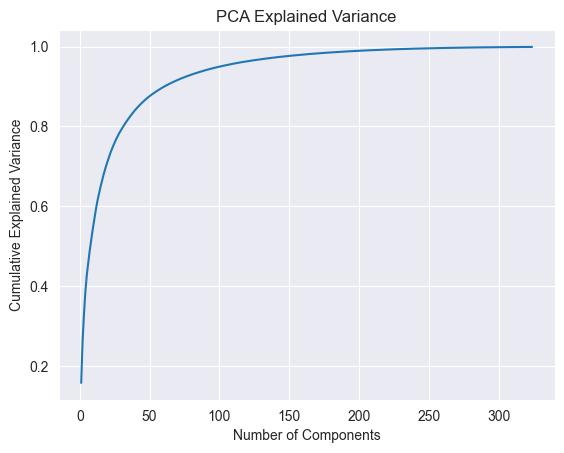

In [37]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
import matplotlib.pyplot as plt

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()
